In [1]:
%load_ext rpy2.ipython

In [2]:
!gist -p internal_model_combine_lof_and_damaging_both_cc_and_dn.ipynb

https://gist.github.com/fc9b3eada2dccdf92af0


In [3]:
%%R
load("/usr/data/Documents/SaveDataFromServer/RSTAN/test_rstan_2016_scz_conditionalCaseControl_andDenovo_combineLoFandDamaging.nChain.3.nThin.2.index.1.dataType.LOF.add_stan2coda.RData")
library("rjags")

by .GlobalEnv when processing object ‘fit’
Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


## Calculate Bayes Factor

In [4]:
!pwd

/usr/data/Documents/GitHub/HierachicalBayesianproject/Model


In [24]:
%%R
###Calculate Bayes Factor
source("../TADA/TADA.R")
ycase <- data$case_damaging + data$case_lof
ycontrol <- data$case_damaging + data$control_lof
ydn <- data$dn_lof + data$dn_damaging
mutAll <- data$mut_lof + data$mut_damaging

ytotal <- ycase + ycontrol
Ncase <- N$ca
Ncontrol <- N$cn
pH0 <- Ncase/(Ncase + Ncontrol)

bfcc <- function(ycase, ytotal, Ncase, Ncontrol,
                 lower.gamma = 1, upper.gamma = Inf,
                 hyperGammaMeanCC = 1.94, hyperBetaCC = 1.98){
  bfH0 <- dbinom(ycase, ytotal, prob = pH0)
  
  
  bfH1 <- apply(cbind(ycase, ytotal), 1, function(x){
    f1 <- function(gamma0)
      dbinom(x[1], x[2], gamma0*Ncase/(gamma0*Ncase + Ncontrol))*dgamma(gamma0, shape = hyperGammaMeanCC*hyperBetaCC,
                                                                        rate = hyperBetaCC)
    return(integrate(f1, lower = lower.gamma, upper = upper.gamma)$value)
  })
  return(bfH1/bfH0)
  
}

bfTempH1 <- apply(cbind(ycase, ytotal), 1, function(x)
  dbinom(x[1], x[2], 1.9*Ncase/(1.9*Ncase + Ncontrol)))
bfTempH0 <- apply(cbind(ycase, ytotal), 1, function(x)
  dbinom(x[1], x[2], pH0))


BFcc <- bfcc(ycase = ycase, ytotal = ytotal, Ncase = N$ca, Ncontrol = N$cn)

BFdn <- bayes.factor.denovo(x = ydn, N = N$dn, mu = mutAll, gamma.mean = 6.8, beta = 1)

BFall <- BFcc*BFdn
cor(BFcc, bfTempH1/bfTempH0)


[1] 0.9684499


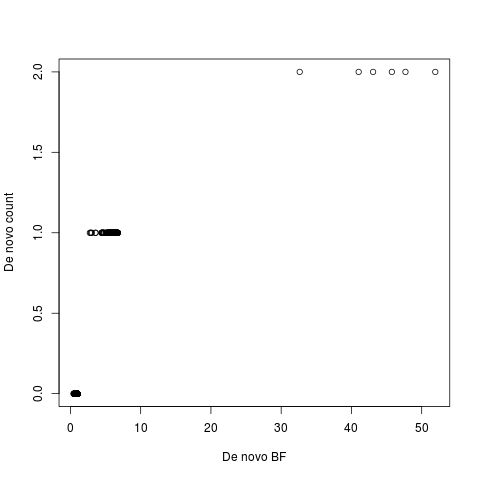

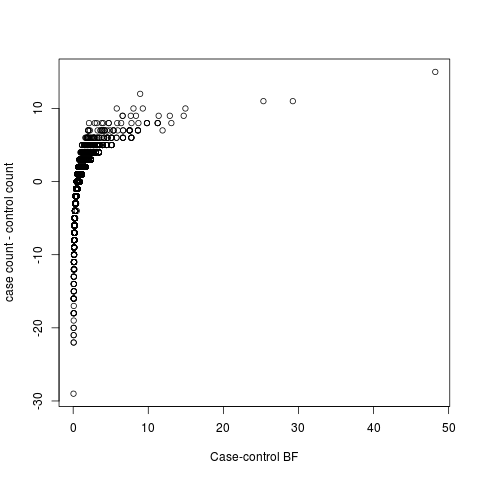

In [25]:
%%R

plot(BFcc, ycase - ycontrol , xlab = 'Case-control BF', ylab = 'case count - control count')
plot(BFdn, ydn, xlab = 'De novo BF', ylab = 'De novo count')

In [29]:
%%R
BFall <- BFcc*BFdn

data$BF <- BFall
data <- data[order(-data$BF),]
pi0 <- 1 - 0.1
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR

data1 <- (data[data$qvalue < 0.3, ])
data1


print(dim(data1))
print(data1)


[1] 19 12
         Gene      mut_lof mut_missense dn_damaging dn_lof control_damaging
550   ALDH1L2 2.290933e-06 2.544296e-05           1      0               13
4942     DPYD 2.614601e-06 2.863038e-05           1      1               22
18219   TAF13 6.247358e-07 3.132438e-06           0      2                1
16614  SETD1A 3.434251e-06 6.973815e-05           0      2                5
11228     MAZ 9.143764e-07 2.793545e-05           0      0                1
609    ALS2CL 2.960004e-06 3.336706e-05           0      1                5
20478    XPO7 3.535579e-06 3.172106e-05           1      0                2
9858     LNX1 1.881175e-06 2.362092e-05           0      0               11
11601   MKI67 4.917779e-06 8.734509e-05           0      2                2
12315 NCKIPSD 1.904592e-06 2.744705e-05           0      1                0
11523     MIF 2.135010e-07 6.279413e-06           0      1                3
10744   LPHN2 3.816321e-06 3.703919e-05           1      1               14
90

In [15]:
%%R -w 28 -h 28 -u cm
library("coda")
summary(s)


Iterations = 1:500
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                          Mean       SD  Naive SE Time-series SE
pi0                  1.036e-01 0.046477 0.0012000      0.0018660
hyperGammaMeanLoFcc  2.012e+00 0.968216 0.0249992      0.0361812
hyperBetaLoFcc       1.900e+00 1.193008 0.0308033      0.0372566
hyperGammaMeanLoFdn  6.676e+00 2.070874 0.0534697      0.0611345
hyperBetaLoFdn       9.996e-01 0.009511 0.0002456      0.0002785
lp__                -2.969e+04 2.027714 0.0523553      0.0659267

2. Quantiles for each variable:

                          2.5%        25%        50%        75%      97.5%
pi0                  4.418e-02  7.272e-02  9.422e-02  1.238e-01  2.225e-01
hyperGammaMeanLoFcc  1.047e+00  1.327e+00  1.720e+00  2.361e+00  4.665e+00
hyperBetaLoFcc       5.429e-01  9.612e-01  1.608e+00  2.566e+00  4.771e+00
hyperGammaMeanLoFdn

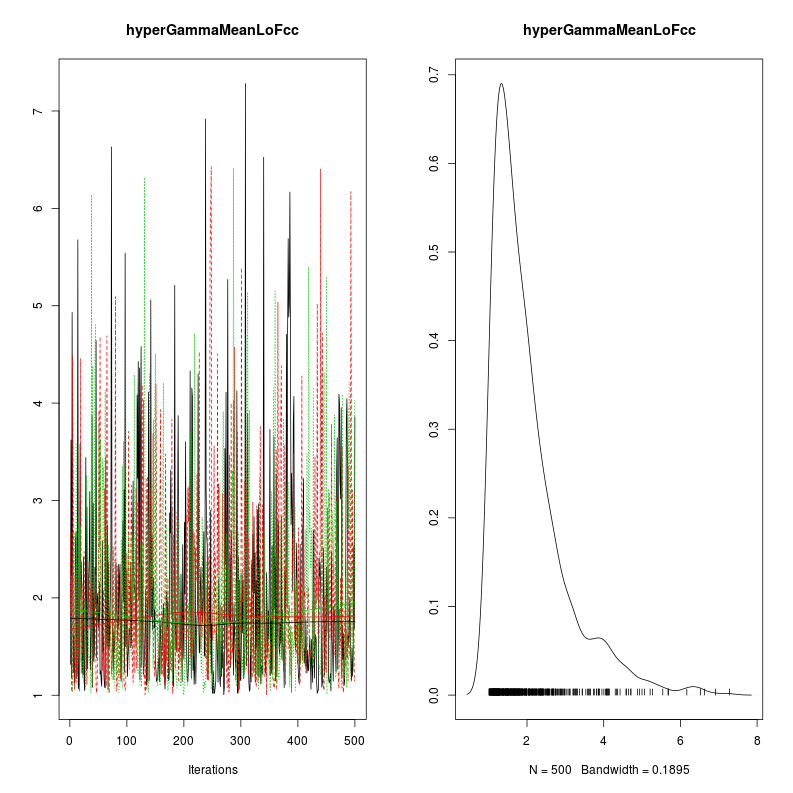

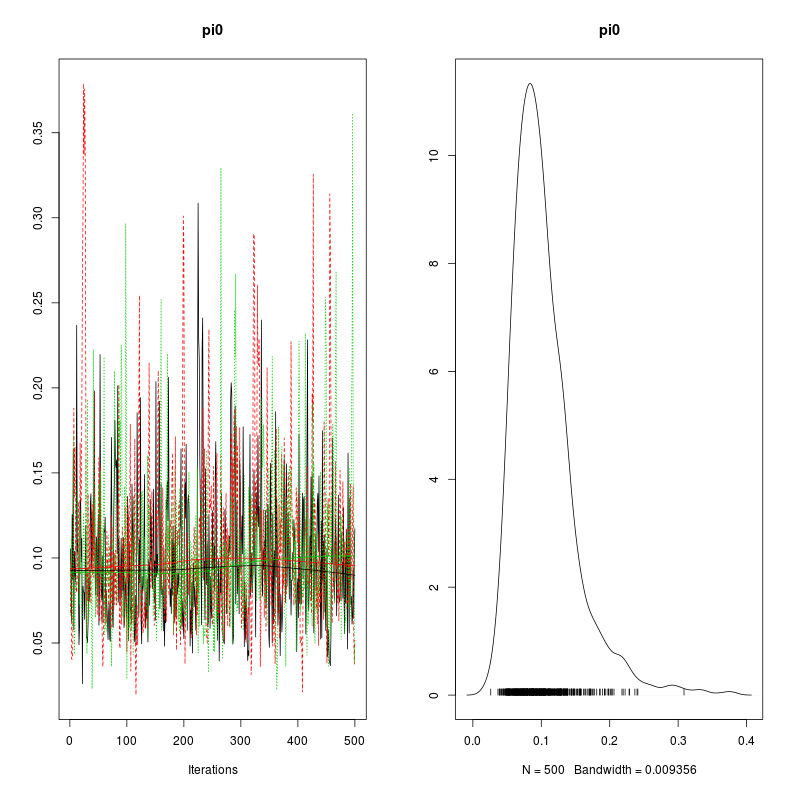

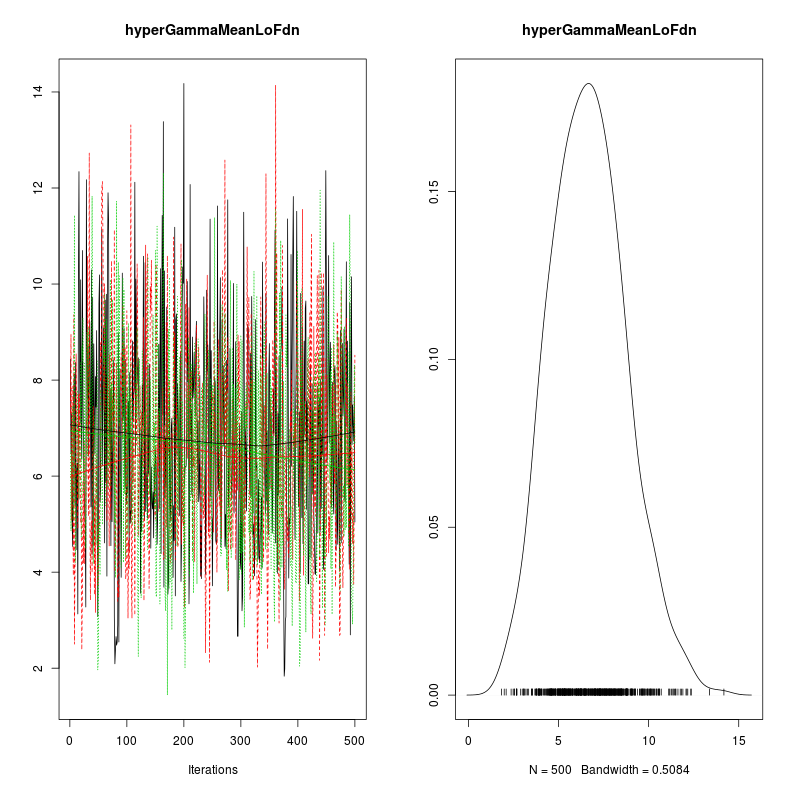

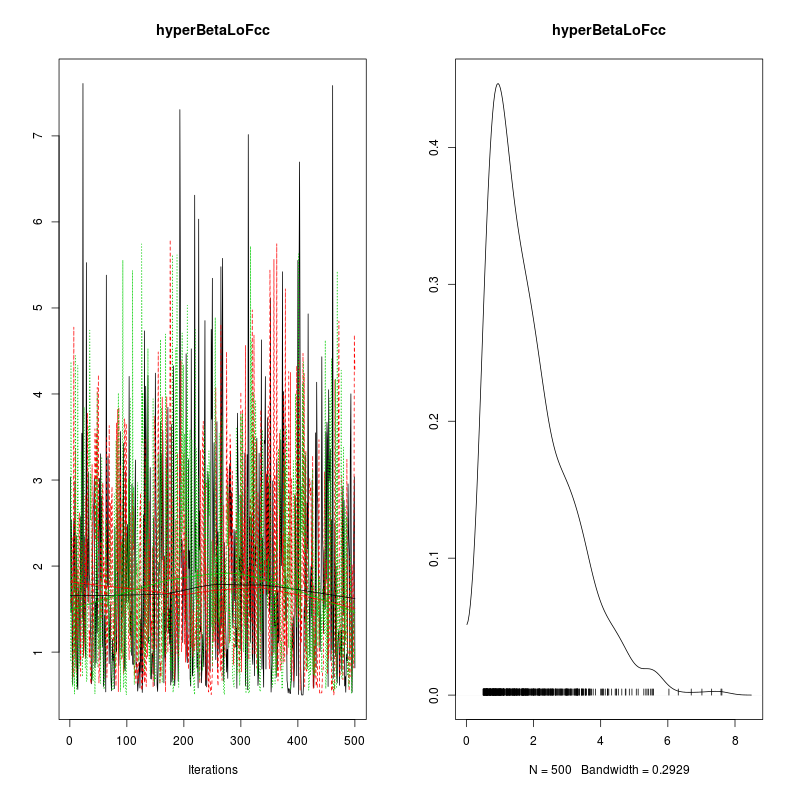

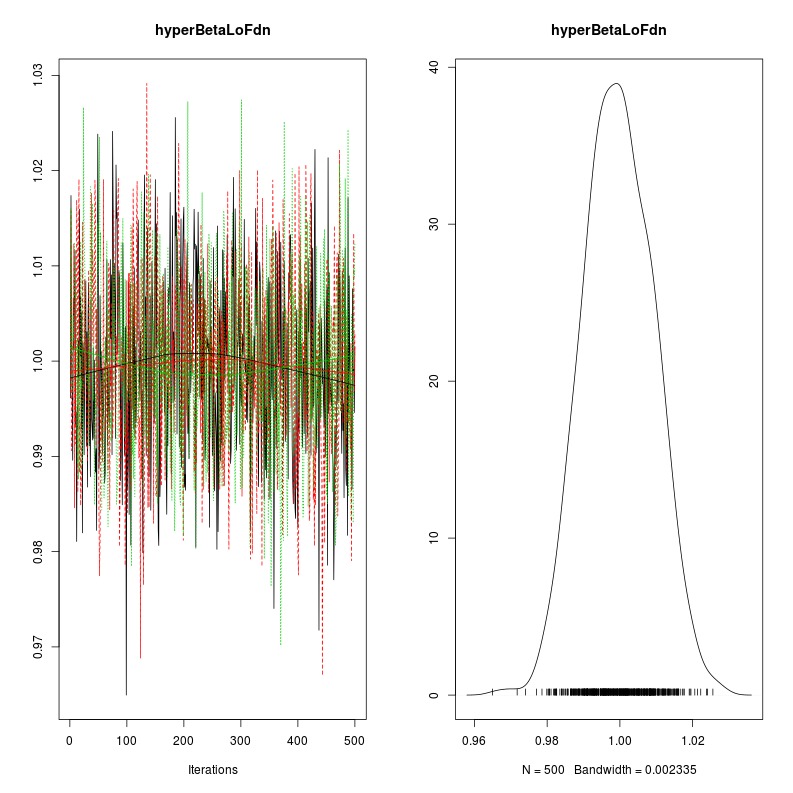

In [16]:
%%R -w 28 -h 28 -u cm
pars <- c('pi0', 'hyperGammaMeanLoFcc', 'hyperGammaMeanLoFdn', 'hyperBetaLoFcc', 'hyperBetaLoFdn')

for (i in pars)
    plot(s[, i], main = i)